# Modeling: Classifying metastasis
## comparing datasets

In [278]:
import sklearn
import pandas as pd
import numpy as np
import math
from scipy.stats import zscore
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# preproc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyClassifier

# grid search CV 
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# metrics for classification
from sklearn.metrics import roc_curve 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier

# import custom functions
import sys
sys.path.append("../")
from projectname import custom_funcs


In [213]:
# custom func
def pretty_confusion_matrix(confmat):

    # this creates the matplotlib graph to make the confmat look nicer
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center', fontsize = 30)
       
    # change the labels
    ax.set_xticklabels(['']+['No Mets', 'Mets'])
    ax.set_yticklabels(['']+['No mets', 'Mets'])
    plt.xlabel('Predicted Label', size = 20)
    plt.ylabel('True Label', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks (fontsize = 20)
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.show()
    

## 0. open the data
NCDB full feature set 

In [214]:
df = pd.read_csv("../data/cleaned/NCDB_cleaned_N924.csv")

Compare NCDB with smaller feature set

In [215]:
df2 = df.drop(columns = ["tumor_lymphocytes", "lymph_vasc_invasion", 
                         "immuno_suppressed", "tumor_depth"])

NCDB + SEER  with reduced feature set

In [283]:
NCDB2 = pd.read_csv("../data/cleaned/NCDB_cleaned_for_SEER_merge.csv")
print("NCDB {}".format(NCDB2.shape[0]))
SEER = pd.read_csv("../data/cleaned/SEER_cleaned_for_NCDB_merge.csv")
print("SEER {}".format(SEER.shape[0]))
# stack rows to merge into single df
df3 = NCDB2.append(SEER)
print("NCDB + SEER {}".format(df3.shape[0]))


NCDB 9109
SEER 1803
NCDB + SEER 10912


## 1.  Prep the data 

- separate features and outcome 
- one-hot encode the categorical variables


In [250]:
# get outcome
df['no_mets'] = df.metastasis.apply(lambda x: 0 if x == 1 else 1)
outcome = df['metastasis']

df2['no_mets'] = df2.metastasis.apply(lambda x: 0 if x == 1 else 1)
outcome2 = df2['metastasis']

df3['no_mets'] = df3.metastasis.apply(lambda x: 0 if x == 1 else 1)
outcome3 = df3['metastasis']

In [251]:
# remove outcome to make feature-only dataset 
features = df.drop(columns =['metastasis', 'no_mets'])
features2 = df2.drop(columns =['metastasis', 'no_mets'])
features3 = df3.drop(columns =['metastasis', 'no_mets'])

In [252]:
# one-hot encode categorical variables  
one_hot_tumor_site = pd.get_dummies(features['tumor_site'], prefix =  "tumor_site")
one_hot_tumor_site2 = pd.get_dummies(features2['tumor_site'], prefix =  "tumor_site")
one_hot_tumor_site3 = pd.get_dummies(features3['tumor_site'], prefix =  "tumor_site")


In [253]:
# Drop the category versions, as it is now encoded
features = features.drop(columns = ['tumor_site'])
features2 = features2.drop(columns = ['tumor_site'])
features3 = features3.drop(columns = ['tumor_site'])

# Join the encoded df to the other features
features = pd.concat([features, one_hot_tumor_site], axis = 1)
features2 = pd.concat([features2, one_hot_tumor_site2], axis = 1)
features3 = pd.concat([features3, one_hot_tumor_site3], axis = 1)


In [ ]:
# standardize continuous variables.
features['AGE'] = zscore(features.AGE, ddof=1)
features2['AGE'] = zscore(features2.AGE, ddof=1)
features3['AGE'] = zscore(features3.AGE, ddof=1)

features['tumor_depth'] = zscore(features.tumor_depth, ddof = 1)
features2['tumor_depth'] = zscore(features2.tumor_depth, ddof = 1)
features3['tumor_depth'] = zscore(features3.tumor_depth, ddof = 1)

features['tumor_size_bins_cm'] = zscore(features.tumor_size_bins_cm, ddof=1)
features2['tumor_size_bins_cm'] = zscore(features2.tumor_size_bins_cm, ddof=1)
features3['tumor_size_bins_cm'] = zscore(features3.tumor_size_bins_cm, ddof=1)


### Split data into train-test sets 
- split the data into train and test sets, automatically 80/20


In [254]:
# split into train-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(features, outcome,
                                                   random_state = 0)
# split into train-test split
X_trainval2, X_test2, y_trainval2, y_test2 = train_test_split(features2, outcome2,
                                                   random_state = 0)
# split into train-test split
X_trainval3, X_test3, y_trainval3, y_test3 = train_test_split(features3, outcome3,
                                                   random_state = 0)

print("NCDB Training data N: {}".format(X_trainval.shape))
print("NCDB Test data N: {}".format(X_test.shape))
print("NCDB Test data outcomes:")
display(custom_funcs.get_proportions(y_test, 'mets'))

NCDB Training data N: (693, 11)
NCDB Test data N: (231, 11)
NCDB Test data outcomes:


,Counts,Percent
mets,,
0.0,156.0,68.0
1.0,75.0,32.0


## Weighted Logistic Regression with CV

Also called Class-weighted or cost-sensitive logistic regression

- logistic regression minimizes the negative log likelihood (loss function)
- by default, errors for each class have the same weighting
- these weightings can be adjusted  based on importance of each class
- larger weight = more importance, mor eupdate to model coefficients

also called importance weightings 

Default setting is to balance based on ratio of classes in dataset.

In [255]:
logit_balanced = LogisticRegression(class_weight = 'balanced', max_iter = 500)

### Split the train-validation dataset into CV folds
- stratifying for the outcome class
- 5 folds, because relatively small N 
- with random re-sampling repeated 5x, to get more confidence of estimates

In [256]:
CV_folds =  RepeatedStratifiedKFold(n_splits = 5, n_repeats =  5,  random_state = 0)


### get cross-validated scores

In [257]:

score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
               'f1': 'f1',
               'roc_auc': 'roc_auc'}


scores = pd.DataFrame(cross_validate(logit_balanced, X_trainval, y_trainval,
                         scoring = score_list, cv = CV_folds, n_jobs = -1))
scores2 = pd.DataFrame(cross_validate(logit_balanced, X_trainval2, y_trainval2,
                         scoring = score_list, cv = CV_folds, n_jobs = -1))
scores3 = pd.DataFrame(cross_validate(logit_balanced, X_trainval3, y_trainval3,
                         scoring = score_list, cv = CV_folds, n_jobs = -1))

In [285]:
balanced_scores = custom_funcs.get_cv_score_table(scores).\
rename(columns = {'Mean Score': 'NCDB with 8 features'})

balanced_scores2 = custom_funcs.get_cv_score_table(scores2).\
rename(columns = {'Mean Score': 'NCDB with 4 features'})

balanced_scores3 = custom_funcs.get_cv_score_table(scores3).\
rename(columns = {'Mean Score': 'NCDB+SEER with 4 features'})

mean_CV_scores = pd.concat([balanced_scores, balanced_scores2, balanced_scores3], axis = 1)

print("Mean cross-validated scores by dataset")
display(mean_CV_scores)
mean_CV_scores.to_csv("../model_output/comparing_datasets_mean_CV_scores.csv")



Mean cross-validated scores by dataset


,NCDB with 8 features,NCDB with 4 features,NCDB+SEER with 4 features
test_acc,0.610,0.552,0.561
test_precision,0.429,0.358,0.372
test_recall,0.561,0.447,0.589
test_f1,0.485,0.396,0.456
test_roc_auc,0.614,0.534,0.596


## Predictions on test set, NCDB 8 features
### Confusion matrix
- This model is  a bit better,
- now only 26 patients who have metastasis are incorrectly classified 
- but alot of people (50) would need to do unnecessary biopsies because we think they have metastasis but they don't.

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


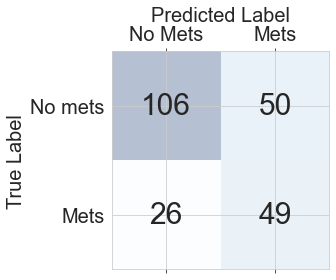

In [259]:
logit_balanced.fit(X_trainval, y_trainval)
y_pred = logit_balanced.predict(X_test)
y_pred_prob = pd.DataFrame(logit_balanced.predict_proba(X_test))[1]
cm = confusion_matrix(y_test, y_pred)
pretty_confusion_matrix(cm)


### if we lower the threshold... 

- lots of false positives, but that's ok
- because only 4 false negatives

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


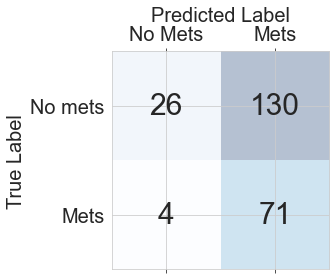

In [260]:
key_thresh = 0.35
y_pred_thresh_lower = y_pred_prob >  key_thresh
cm = confusion_matrix(y_test, y_pred_thresh_lower)
pretty_confusion_matrix(cm)


In [266]:
true_negatives = cm[0,0]
total_cases = y_test.shape[0]
prop_no_biopsy =  (true_negatives / total_cases)*100
print("Patients with low risk metastasis, no biopsy: {} %".format(round(prop_no_biopsy,2)))

Patients with low risk metastasis, no biopsy: 11.26 %


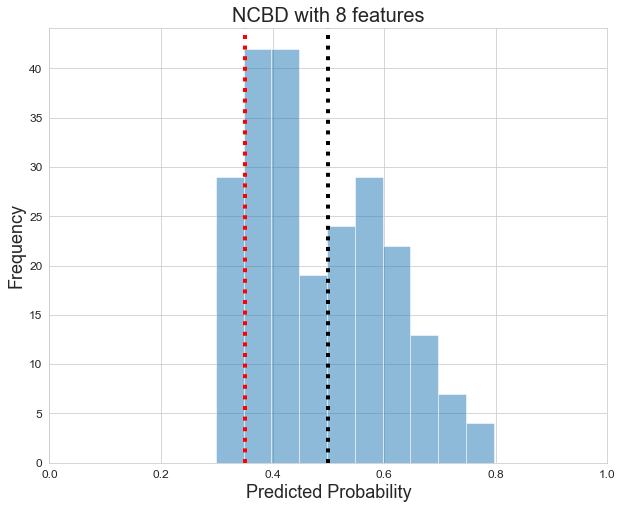

In [277]:
plt.figure(figsize = (10, 8))
plt.hist(y_pred_prob, alpha = 0.5)
plt.axvline(linewidth = 4, color = "red", linestyle = "dotted", x = key_thresh)
plt.axvline(linewidth = 4, color = "black", linestyle = "dotted", x = 0.5)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlim(0, 1)
plt.xlabel("Predicted Probability", size = 18)
plt.ylabel ("Frequency",  size = 18)
plt.title("NCBD with 8 features", size = 20)
plt.savefig("../figures/comparing_datasets/PredProb_NCDB_8_features.png")
plt.show()


- there is actually a binomial distribution, sort-of,  here 

## Predictions on test set, with 4 features
### confusion matrix

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


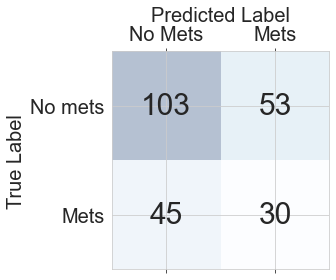

In [227]:
logit_balanced.fit(X_trainval2, y_trainval2)
y_pred2 = logit_balanced.predict(X_test2)
y_pred_prob2 = pd.DataFrame(logit_balanced.predict_proba(X_test2))[1]
cm = confusion_matrix(y_test2, y_pred2)
pretty_confusion_matrix(cm)

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


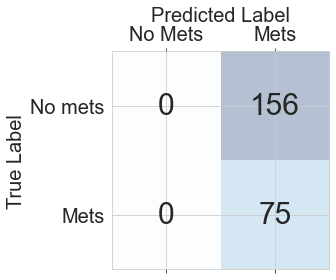

In [228]:
# the radtio of true negatives to false negatives is not great.
y_pred_thresh_lower2 = y_pred_prob2 > key_thresh
cm = confusion_matrix(y_test2, y_pred_thresh_lower2)
pretty_confusion_matrix(cm)


In [ ]:
true_negatives = cm[0,0]
total_cases = y_test.shape[0]
prop_no_biopsy =  (true_negatives / total_cases)*100
print("Patients with low risk metastasis, no biopsy: {} %".format(round(prop_no_biopsy,2)))

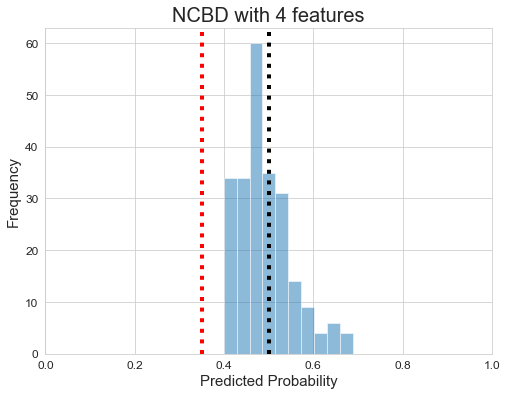

In [241]:
plt.figure(figsize = (8, 6))
plt.hist(y_pred_prob2, alpha = 0.5)
plt.axvline(linewidth = 4, color = "red", linestyle = "dotted", x = key_thresh)
plt.axvline(linewidth = 4, color = "black", linestyle = "dotted", x = 0.5)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlim(0, 1)
plt.xlabel("Predicted Probability", size =  15)
plt.ylabel ("Frequency",  size = 15)
plt.title("NCBD with 4 features", size = 20)
plt.savefig("../figures/comparing_datasets/PredProb_NCDB_4_features.png")
plt.show()


## Predictions on test set, NCDB+SEER 4 features

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


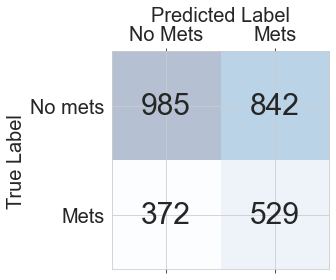

In [267]:
logit_balanced.fit(X_trainval3, y_trainval3)
y_pred3 = logit_balanced.predict(X_test3)
y_pred_prob3 = pd.DataFrame(logit_balanced.predict_proba(X_test3))[1]
cm = confusion_matrix(y_test3, y_pred3)
pretty_confusion_matrix(cm)

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


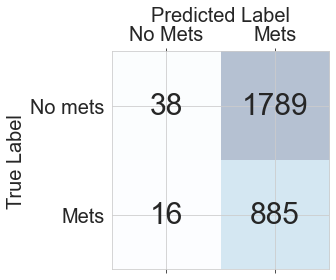

In [268]:
# the radtio of true negatives to false negatives is not great.
y_pred_thresh_lower3 = y_pred_prob3 > key_thresh
cm = confusion_matrix(y_test3, y_pred_thresh_lower3)
pretty_confusion_matrix(cm)


In [272]:
true_negatives = cm[0,0]
total_cases = y_test3.shape[0]
prop_no_biopsy =  (true_negatives / total_cases)*100
print("Patients with low risk metastasis, no biopsy: {} %".format(round(prop_no_biopsy,2)))

Patients with low risk metastasis, no biopsy: 1.39 %


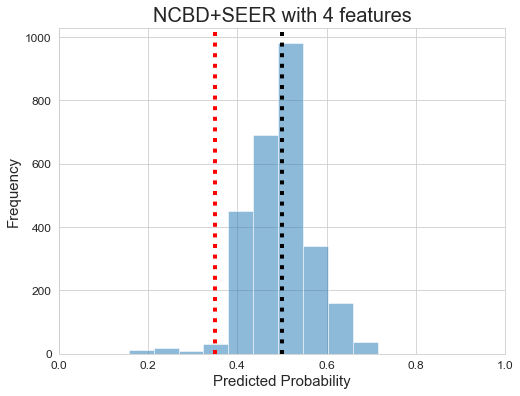

In [270]:
plt.figure(figsize = (8, 6))
plt.hist(y_pred_prob3, alpha = 0.5)
plt.axvline(linewidth = 4, color = "red", linestyle = "dotted", x = key_thresh)
plt.axvline(linewidth = 4, color = "black", linestyle = "dotted", x = 0.5)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlim(0, 1)
plt.xlabel("Predicted Probability", size =  15)
plt.ylabel ("Frequency",  size = 15)
plt.title("NCBD+SEER with 4 features", size = 20)
plt.savefig("../figures/comparing_datasets/PredProb_NCDB_SEER_4_features.png")
plt.show()


## Comparing models: 
### PR curve

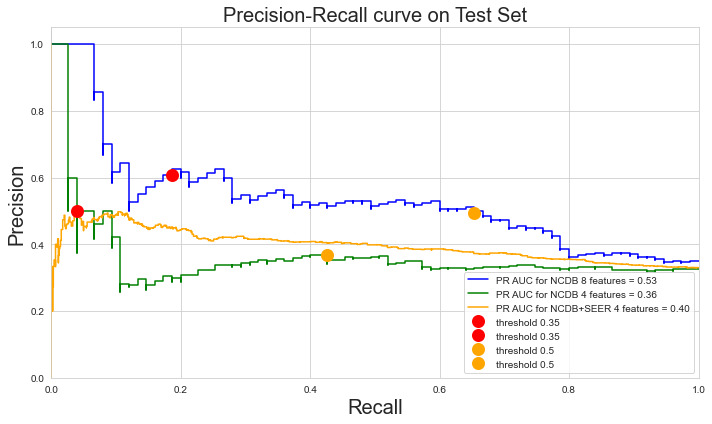

In [242]:
precision, recall, thresh = precision_recall_curve(y_test, y_pred_prob)
precision2, recall2, thresh2  = precision_recall_curve(y_test2, y_pred_prob2)
precision3, recall3, thresh3  = precision_recall_curve(y_test3, y_pred_prob3)

# get scores 
auc_score = auc(recall, precision)
auc_score2 = auc(recall2, precision2)
auc_score3 = auc(recall3, precision3)
# get thresh
thresh_lower = np.argmin(np.abs(thresh - 0.65))
thresh_default = np.argmin(np.abs(thresh - 0.5))
thresh2_lower = np.argmin(np.abs(thresh2 - 0.65))
thresh2_default = np.argmin(np.abs(thresh2 - 0.5))

# plot 
plt.figure(figsize = (10, 6))
plt.step(recall, precision,  where='post',  color = "blue",
    label='PR AUC for NCDB 8 features = %0.2f'% auc_score)
plt.step(recall2, precision2, where = 'post', color = "green",
    label='PR AUC for NCDB 4 features = %0.2f'% auc_score2)
plt.step(recall3, precision3, where = 'post', color = "orange",
    label='PR AUC for NCDB+SEER 4 features = %0.2f'% auc_score3)
plt.plot(recall[thresh_lower], precision[thresh_lower], 'o', markersize = 10,
        label = "threshold 0.35", mew = 3, color = "red")
plt.plot(recall2[thresh2_lower], precision2[thresh2_lower], 'o', markersize = 10,
        label = "threshold 0.35", mew = 3, color = "red")
plt.plot(recall[thresh_default], precision[thresh_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "orange")
plt.plot(recall2[thresh2_default], precision2[thresh2_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "orange")
plt.xlabel('Recall', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve on Test Set', fontsize = 20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/comparing_datasets/PR_curve_NCDB_vs_SEER.png")
plt.show()


###  ROC curve

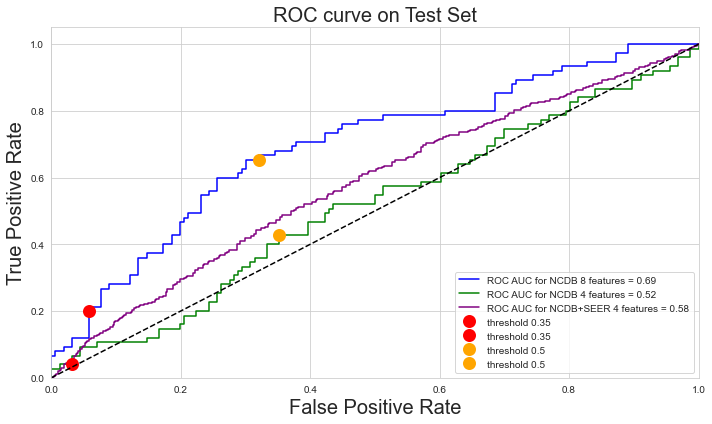

In [279]:

fpr, tpr, thresh = roc_curve(y_test, y_pred_prob)
fpr2, tpr2, thresh2 = roc_curve(y_test2, y_pred_prob2)
fpr3, tpr3, thresh3 = roc_curve(y_test3, y_pred_prob3)
# get scores 
auc_score = auc(fpr, tpr)
auc_score2 = auc(fpr2, tpr2)
auc_score3 = auc(fpr3, tpr3)
# get thresh
thresh_lower = np.argmin(np.abs(thresh - 0.65))
thresh_default = np.argmin(np.abs(thresh - 0.5))
thresh2_lower = np.argmin(np.abs(thresh2 - 0.65))
thresh2_default = np.argmin(np.abs(thresh2 - 0.5))

# plot 
plt.figure(figsize = (10,6))
plt.step(fpr, tpr,  where='post',  color = "blue",
    label='ROC AUC for NCDB 8 features = %0.2f'% auc_score)
plt.step(fpr2, tpr2, where = 'post', color = "green",
    label='ROC AUC for NCDB 4 features = %0.2f'% auc_score2)
plt.step(fpr3, tpr3, where = 'post', color = "purple",
    label='ROC AUC for NCDB+SEER 4 features = %0.2f'% auc_score3)
plt.plot(fpr[thresh_lower], tpr[thresh_lower], 'o', markersize = 10,
        label = "threshold 0.35", mew = 3, color = "red")
plt.plot(fpr2[thresh2_lower], tpr2[thresh2_lower], 'o', markersize = 10,
        label = "threshold 0.35", mew = 3, color = "red")
plt.plot(fpr[thresh_default], tpr[thresh_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "orange")
plt.plot(fpr2[thresh2_default], tpr2[thresh2_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "orange")
plt.plot([0,1], [0,1], color = "black", linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve on Test Set', fontsize = 20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/comparing_datasets/ROC_curve_NCDB_vs_SEER.png")


### Summary of results
**For positive cases of metastasis:**

- Precision is perfect, because no false positives to predict metastasis.
- But recall  is very poor,  because many false negatives (positive cases going undetected, bad!!)
-- We need better recall.

**For negative cases:**
- Precision is 76%, because about 1/3 of positive cases are incorrectly classified as negative cases.
- Recall is perfect, because no negative cases were incorrectly classified as positive.



### what if we change threshold for classification?
- ideally want to know  if we can detect a patient with <5 % chance of metastasis 
- we can change the threshold of  the predictions! 
-- more towards positive class, especially if we care about high recall 
--  and care less about false positives.
--  to do this, we can lower the threshold that gets counted as a positive class

if we change threshold to 0.05, we don't have any 'true negative' patients that are predicted to be negative

becasue everyone's predicted probability of a positive case is > 0.05!! 

# How to optimize model selection  for predicting  NEGATIVE class

1) use negative  class's recall as our metric to compare 

2) change threshold to 5% likelihood?

3) get confidence intervals around predictions